### Multi-level Movie Genre classification with IMDB data

This notebook creates and explores a model that can be used to predict multiple genres based on a movie plot. The model is trained by IMDB data by extracting the most popular movies for various movie genres. It can be extended by using transfer learning with a pretrained model, or for example to predict the movie genre based on its poster. 
Currently, I have only used one column from the IMDB dataframe to classify movies, but there is much more data available in this dataframe.

### Get IMDB ids

From IMDB, we extract the 50 most popular movies by genres. I selected 'Comedy', 'Action', 'Animation', 'Romance' and 'Horror'.


In [126]:
# extract top 100 movie IDs from IMDB
# based on https://abdulrwahab.medium.com/how-to-build-a-python-web-scraper-to-capture-imdb-top-100-movies-908bf9b6bc19
import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# Define movie genres to query
genres = ['Comedy', 'Action', 'Animation', 'Romance', 'Horror']
# for each genre grab the top 50 movies
imdb_url = "https://www.imdb.com/search/title/?genres={}&explore=genres&title_type=feature&ref_=ft_movie_0"

# Step 3: Set headers.
headers = {"Accept-Language": "en-US, en;q=0.5"}


imdbid_list = []
for genre in genres:
    # Step 4: Save all values to the results objects coming back from the .get on IMDb URL.
    results = requests.get(imdb_url.format(genre), headers=headers)

    # Step 5: Parse the results object to movie_soup using the html parser.
    movie_soup = BeautifulSoup(results.text, "html.parser")

    # Step 7: Create a movie_div object to find all div objects in movie_soup.
    movie_div = movie_soup.find_all('div', class_='lister-item mode-advanced')

    for store in movie_div:
        imdbID = store.img.get('data-tconst')
        imdbid_list.append(imdbID)

In [127]:
# remove duplicates to make sure we don't query for the same movie multiple times
imdbid_list = list(dict.fromkeys(imdbid_list))
print(len(imdbid_list))

206


## Get data from OMDB api

Based on the list of IMDB ids, we query the OMDB api to extract extra data for each movie, like movie plot, box office, language etc. 

In [128]:
# Load key to acces OMDB api
key = open('../api-key/omdb key.txt', 'r').read()

In [129]:
import pandas as pd
import requests
import json

# helper functions
def getratings(ratinglist):
    """ 
    getratings converts a list of dictionaries with different rating sources and values into a list of lists
    :param ratinglist: list of dictionaries
    :return:  list in format [[source, value][source, value]]
       """
    returnlist = []
    for rating in ratinglist:
        dict_r = dict(rating)
        return_r = [dict_r['Source'], dict_r['Value']]
        returnlist.append(return_r)
    return returnlist

def load_data(key, idlist):
    """ 
    load_data extracts movie data from OMDB API, based on a list of words provided in searchlist
    :param key: apikey to access the api
    :param searchlist: list of stings to search for in movie titles
    :return:  for each word in searchlist, 10 movies with the word in its title and corresponding omdb data
    """
    # initialize empty dataframe
    moviedf = pd.DataFrame()

    # for each imdb id, extract data from omdb api
    for id in idlist:
        response_data = requests.get('http://www.omdbapi.com/?apikey={}&i={}&plot=full'.format(key, id))
        data_txt = response_data.text
        if 'Title' in data_txt:
            parse_data = pd.read_json(data_txt)
            # convert multiple rows per movie into 1 row per movie by groupby and applying a function to 'Ratings' column
            groupby_cols = list(parse_data.columns)
            groupby_cols.remove('Ratings')
            parse_data = (parse_data.groupby(groupby_cols)
            .agg({'Ratings': lambda x: getratings(x)},axis=1)
            .reset_index())
            
            # add data to the final dataframe
            moviedf = pd.concat([moviedf, parse_data])
    # make sure there are no duplicates
    moviedf.reset_index(drop=True, inplace=True)
    moviedf = moviedf.loc[moviedf.astype(str).drop_duplicates().index]
    moviedf.to_excel('test.xlsx')
    return moviedf

### Data exploration and preprocessing

In [130]:
import pandas as pd
moviedf = load_data(key, imdbid_list)
# moviedf = pd.read_excel('backup data.xlsx')
moviedf.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Ratings
0,Haunted Mansion,2023.0,PG-13,28 Jul 2023,122 min,"Comedy, Drama, Family",Justin Simien,Katie Dippold,"Rosario Dawson, Jamie Lee Curtis, Winona Ryder","A single mom named Gabbie hires a tour guide, ...",...,N/A,N/A,tt1695843,movie,N/A,N/A,N/A,N/A,True,"[[Rotten Tomatoes, 42%]]"
1,Babylon,2022.0,R,23 Dec 2022,189 min,"Comedy, Drama, History",Damien Chazelle,Damien Chazelle,"Brad Pitt, Margot Robbie, Jean Smart",A tale of outsized ambition and outrageous exc...,...,7.2,"130,837",tt10640346,movie,31 Jan 2023,"$15,351,455",N/A,N/A,True,"[[Internet Movie Database, 7.2/10], [Rotten To..."
2,Asteroid City,2023.0,PG-13,23 Jun 2023,105 min,"Comedy, Drama, Romance",Wes Anderson,"Wes Anderson, Roman Coppola","Jason Schwartzman, Scarlett Johansson, Tom Hanks",Following a writer on his world famous fiction...,...,7,"45,973",tt14230388,movie,11 Jul 2023,"$27,272,775",N/A,N/A,True,"[[Internet Movie Database, 7.0/10], [Rotten To..."
3,The Out-Laws,2023.0,R,07 Jul 2023,95 min,"Action, Comedy, Crime",Tyler Spindel,"Ben Zazove, Evan Turner","Adam Devine, Pierce Brosnan, Ellen Barkin",A straight-laced bank manager about to marry t...,...,5.4,"22,052",tt11274492,movie,N/A,N/A,N/A,N/A,True,"[[Internet Movie Database, 5.4/10], [Metacriti..."
4,Guardians of the Galaxy Vol. 3,2023.0,PG-13,05 May 2023,150 min,"Action, Adventure, Comedy",James Gunn,"James Gunn, Jim Starlin, Stan Lee","Chris Pratt, Chukwudi Iwuji, Bradley Cooper","Still reeling from the loss of Gamora, Peter Q...",...,8.1,"218,674",tt6791350,movie,07 Jul 2023,"$358,552,074",N/A,N/A,True,"[[Internet Movie Database, 8.1/10], [Rotten To..."


In [132]:
# The amount of movies in the dataset
print(len(moviedf))

172


In [133]:
# Define the different column types in the dataframe, possibly to extend the model in the future
num_cols = ['Runtime', 'Metascore', 'imdbRating', 'imdbVotes', 'BoxOffice']
text_cols = ['Plot', 'Title']
# We will try to predict the genre based on the movie plots, thus X=Plot and y=Genre
X_cols = 'Plot'
y_col = 'Genre'

In [134]:
# If present, remove rows with NAN genre
moviedf = moviedf[moviedf['Genre'].notna()]

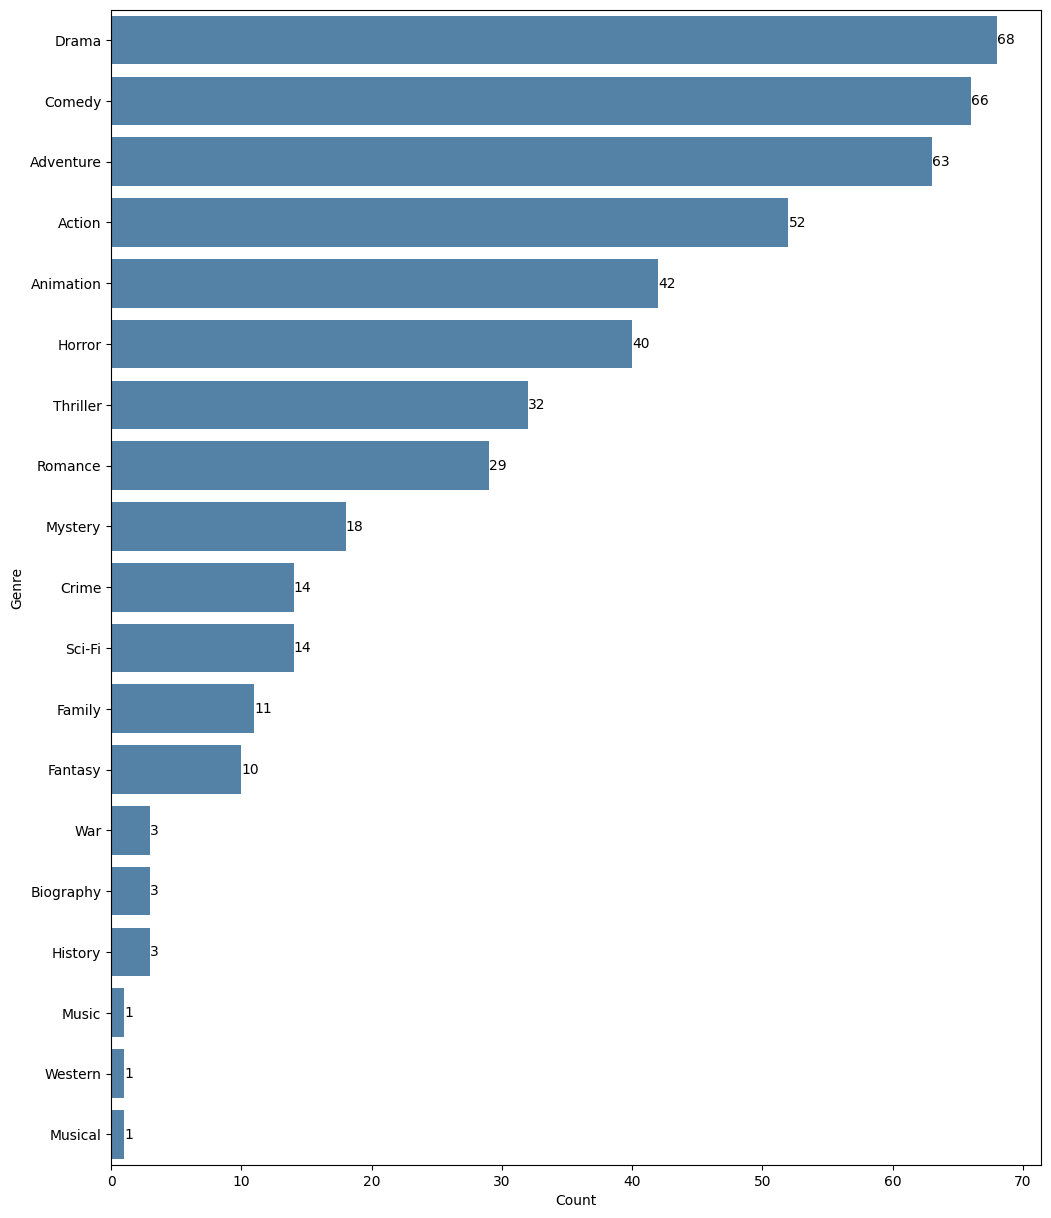

In [135]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# plot the occurences of movie genres in the dataset
moviedf[y_col] = moviedf[y_col].apply(lambda x: x.split(', '))
genre_list = [item for sublist in moviedf['Genre'] for item in sublist]
count = Counter(genre_list)
countdf = pd.DataFrame.from_dict(count, orient='index', columns=['Count']).reset_index().sort_values(by='Count', ascending=False)

plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=countdf, x="Count", y = "index", color='steelblue') 
for i in ax.containers:
    ax.bar_label(i,)
ax.set(ylabel = 'Genre') 
plt.show()

By plotting the occurences per genre in the dataset, we can see that the classes are imbalanced. Since some genres occur rarely, we will remove them from the dataset. Moreover, we will apply a simple preprocessing step to the movie plots data, so that all the text is lowercase and without puntuation.

In [136]:
import re, string


def remove_genre(x, genre):
    """ 
    Removes classes with less than 4 instances
    :param x: list of genres
    :param genre:  genre to remove (str)
    :return:  list without genre to remove
    """
    if genre in x:
        x.remove(genre)
    return x

def process_text(text):
    """ 
    Make text lowercase and remove punctuation
    :param text: string to process
    :return: processed string
    """
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

    
less_than_4 = list(countdf.loc[countdf['Count'] < 4]['index'])
for genre in less_than_4:
    moviedf['Genre'] = moviedf['Genre'].apply(lambda x: remove_genre(x, genre))

Next, we define our predictor variable X = plot, and our target variables y = genre. Since movies can have multiple genres, we use multilabelBinarizer to encode y.

In [137]:
from sklearn.preprocessing import MultiLabelBinarizer
# define X and y
X = moviedf['Plot'].apply(process_text)
multilabel_binarizer = MultiLabelBinarizer()
y = multilabel_binarizer.fit_transform(moviedf[y_col])
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [138]:
# print the classes in y
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller'], dtype=object)

### Pipeline Setup

Now we will split our data into training and testing data and define our model pipeline

In [139]:
from sklearn.model_selection import train_test_split
# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(137,) (35,) (137, 13) (35, 13)


We use tfidf vectorizer to transform our movie plots into a meaningul representation of numbers. 
To account for overfitting, we use a featureselection model selectKBes. 
We use a onevsrestclassifer with a randomforest classifier to support multi-label classification. Using gridsearch, the types of classifiers can be changed in the future to improve the model.

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# Load TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 2))

# load feature selection step
select_k_best = SelectKBest(score_func=chi2, k=25)

# Load the RandomForestClassifier
random_forest_clf = RandomForestClassifier(class_weight='balanced')

data_pipeline = Pipeline([
    ('text_feat', tfidf_vectorizer),
    ('feature_selection', select_k_best),
    ('clf', OneVsRestClassifier(random_forest_clf))
])



With gridsearch, we perform hyperparameter tuning and cross validation to train our model

In [142]:
# Parameters for Grid Search
param_grid = [{
    'text_feat__max_df': [0.7, 0.8, 0.9],
    'feature_selection__k': [50, 25, 10],
    'clf__estimator__n_estimators': [50, 100, 200]
}]

# Grid Search
grid_search= GridSearchCV(data_pipeline, param_grid, cv=3, return_train_score=True, refit=True,
                        scoring='f1_micro',
                        verbose=1)
grid_search.fit(X_train, y_train)

# Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Best Model from Grid Search
best_model = grid_search.best_estimator_

# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'clf__estimator__n_estimators': 200, 'feature_selection__k': 50, 'text_feat__max_df': 0.7}
Best Score: 0.36309732435242986


Lets see what the score is on unseen data

In [178]:
from sklearn.metrics import f1_score

# evaluate model performance
f1_score(y_test, y_pred_test, average="micro")

0.4210526315789474

The model score is not perfect yet, it might be better to use a pretrained model in the future, like BERT, or to include more features and instances.

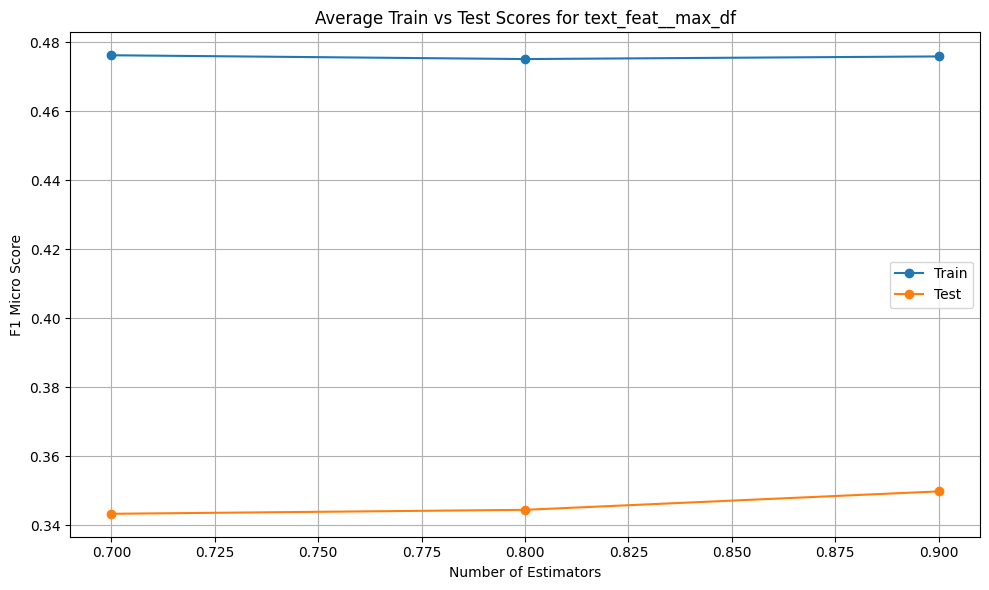

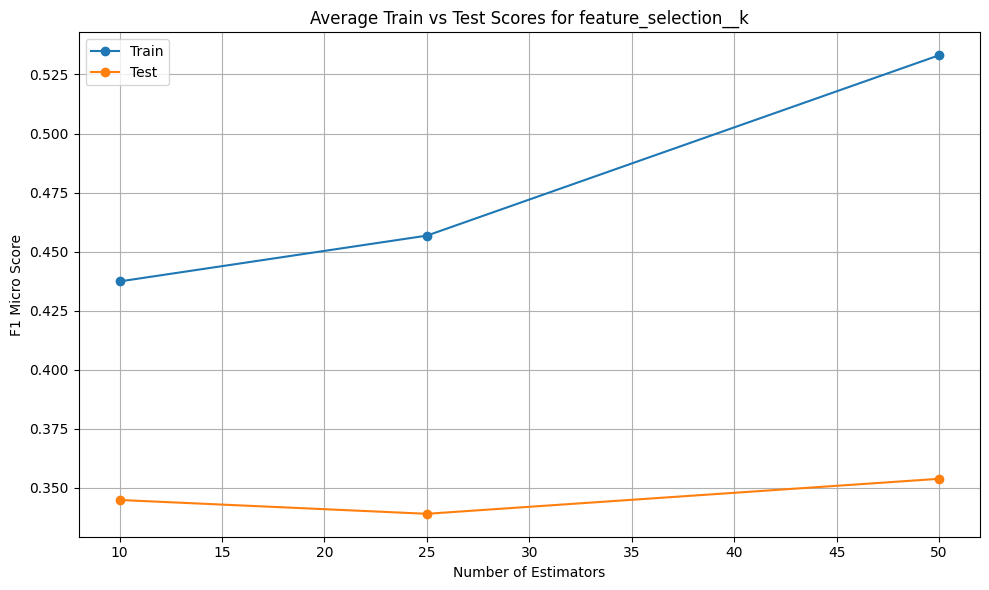

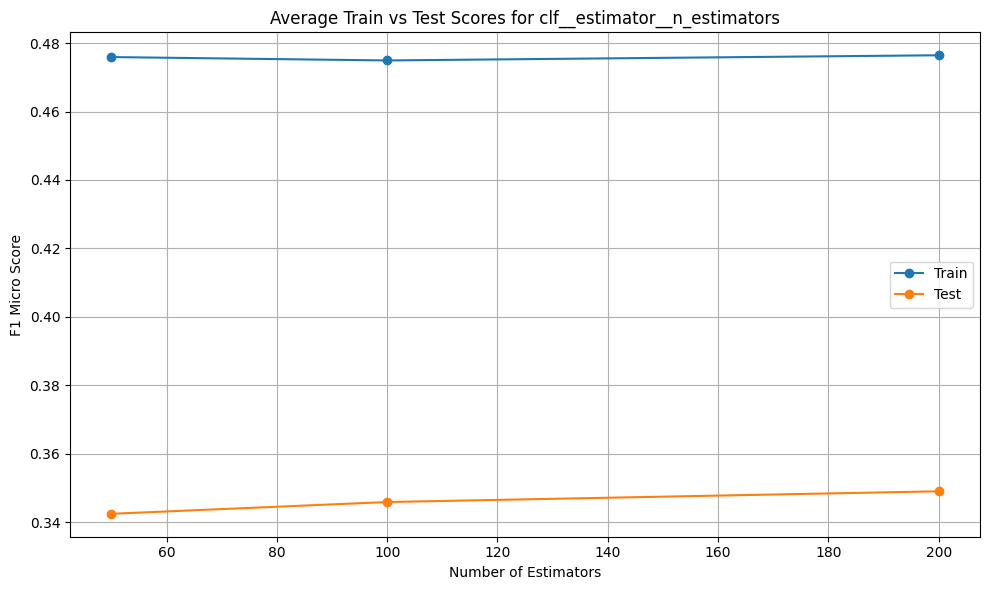

In [158]:
import matplotlib.pyplot as plt

for key in param_grid[0]:
    # Get the values of the hyperparameter you want to analyze
    param_name = 'param_' + key
    param_values = grid_search.cv_results_[param_name]

    # Get the mean train and test scores
    train_scores = grid_search.cv_results_['mean_train_score']
    test_scores = grid_search.cv_results_['mean_test_score']

    # Group the data by hyperparameter values and calculate the mean scores for each group
    mean_scores_df = pd.DataFrame({param_name: param_values, 'train_score': train_scores, 'test_score': test_scores})
    mean_scores = mean_scores_df.groupby(param_name).mean().reset_index()

    # Set up the figure
    plt.figure(figsize=(10, 6))

    # Plot train scores
    plt.plot(mean_scores[param_name], mean_scores['train_score'], label='Train', marker='o', linestyle='-')

    # Plot test scores
    plt.plot(mean_scores[param_name], mean_scores['test_score'], label='Test', marker='o', linestyle='-')

    # Add labels and title
    plt.xlabel('Number of Estimators')
    plt.ylabel('F1 Micro Score')
    plt.title('Average Train vs Test Scores for {}'.format(key))
    plt.grid()
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()





We can see that as soon as the amount of features increase, the model starts overfitting more. The least amount of features in our classification model lead to the best test scores. Next, we will investigate the results for all the tested model in a heatmap by investigating the mean test score for the combinations between two of our hyperparameters

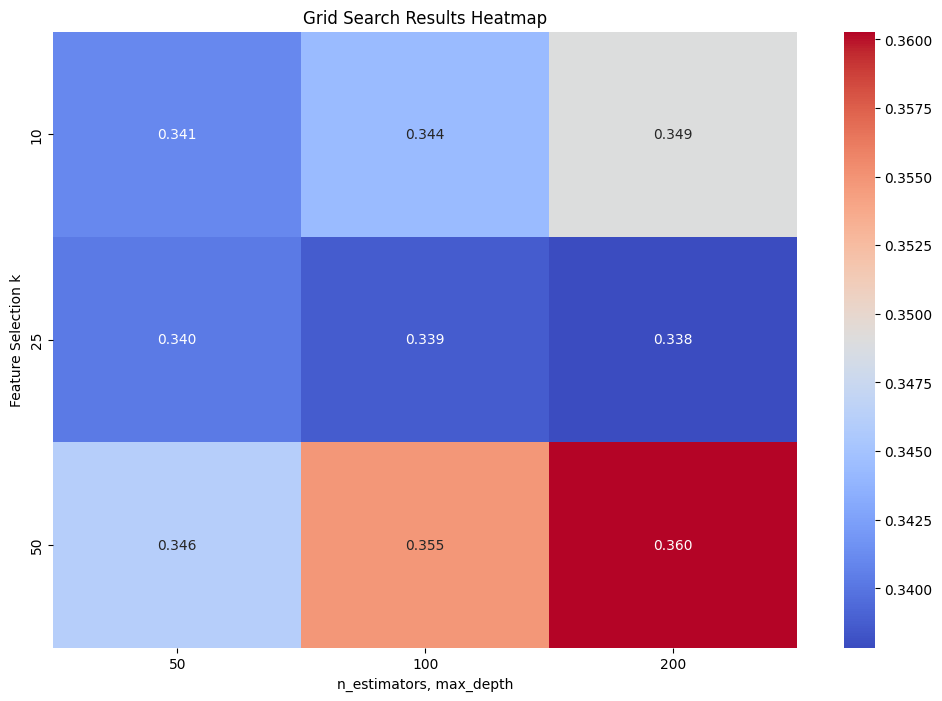

In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the grid search results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Extract the relevant columns for plotting
columns_for_plot = ['param_feature_selection__k', 'param_clf__estimator__n_estimators', 'param_text_feat__max_df', 'mean_test_score']

results_df = results_df[columns_for_plot]

# Pivot the DataFrame for plotting
pivoted_results = results_df.pivot_table(index=['param_feature_selection__k', 'param_clf__estimator__n_estimators'],
                                         values='mean_test_score',
                                         aggfunc='mean')

# Reshape the DataFrame for plotting
heatmap_df = pivoted_results.reset_index().pivot(index='param_feature_selection__k',
                                                columns=['param_clf__estimator__n_estimators'],
                                                values='mean_test_score')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt='.3f', cbar=True)
plt.title('Grid Search Results Heatmap')
plt.xlabel('n_estimators, max_depth')
plt.ylabel('Feature Selection k')
plt.show()

This plot also shows that the least amount of features give the best test results for our model

Currently the predictions made by the model are based on a threshold value of 0.5, we can inspect this threshold value to see if a higher or lower value might lead to better results.

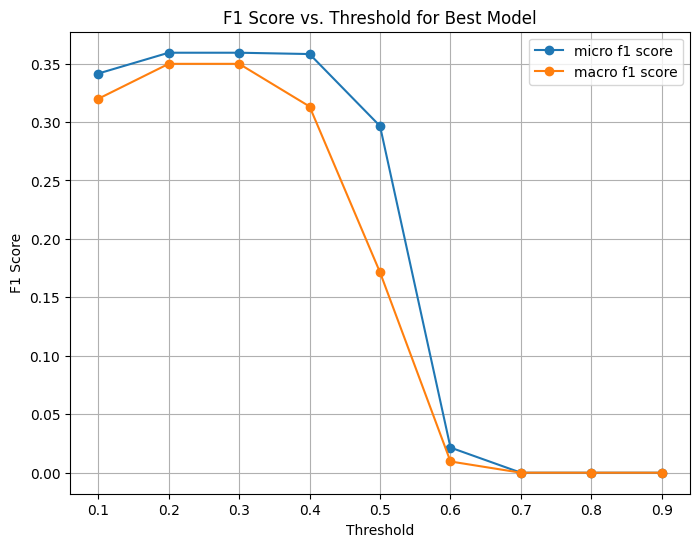

In [92]:
# Compute F1 scores for different thresholds for the best model
from sklearn.metrics import f1_score


thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores_micro = []
f1_scores_macro = []

for threshold in thresholds:
    y_val_probs = grid_search.predict_proba(X_test) 
    y_val_pred = (y_val_probs >= threshold).astype(int)
    f1_scores_micro.append(f1_score(y_test, y_val_pred, average='micro'))
    f1_scores_macro.append(f1_score(y_test, y_val_pred, average='macro'))

# Plot the F1-score vs. threshold for the best model
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores_micro, marker='o', label='micro f1 score')
plt.plot(thresholds, f1_scores_macro, marker='o', label='macro f1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold for Best Model')
plt.grid(True)
plt.legend()
plt.show()


As we can see, a value of 0.3 or 0.4 might actually be better for this model, as it minimizes the gap between the micro and macro f1 score and gives the highest scores. But..... if we look at the actual predictions, we can see that if we lower the threshold, the model just predicts every genre.

In [173]:
# predict genres based on new threshold
y_test_probs = grid_search.predict_proba(X_test) 
y_test_pred = (y_val_probs >= 0.3).astype(int)
y_test_pred

array([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

So we will leave the threshold as is and we will plot the confusion matrix for each genre. 

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = np.asarray(labels).reshape(2,2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", ax=axes, cmap='Blues', annot_kws={"size": 16})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class - " + class_label)

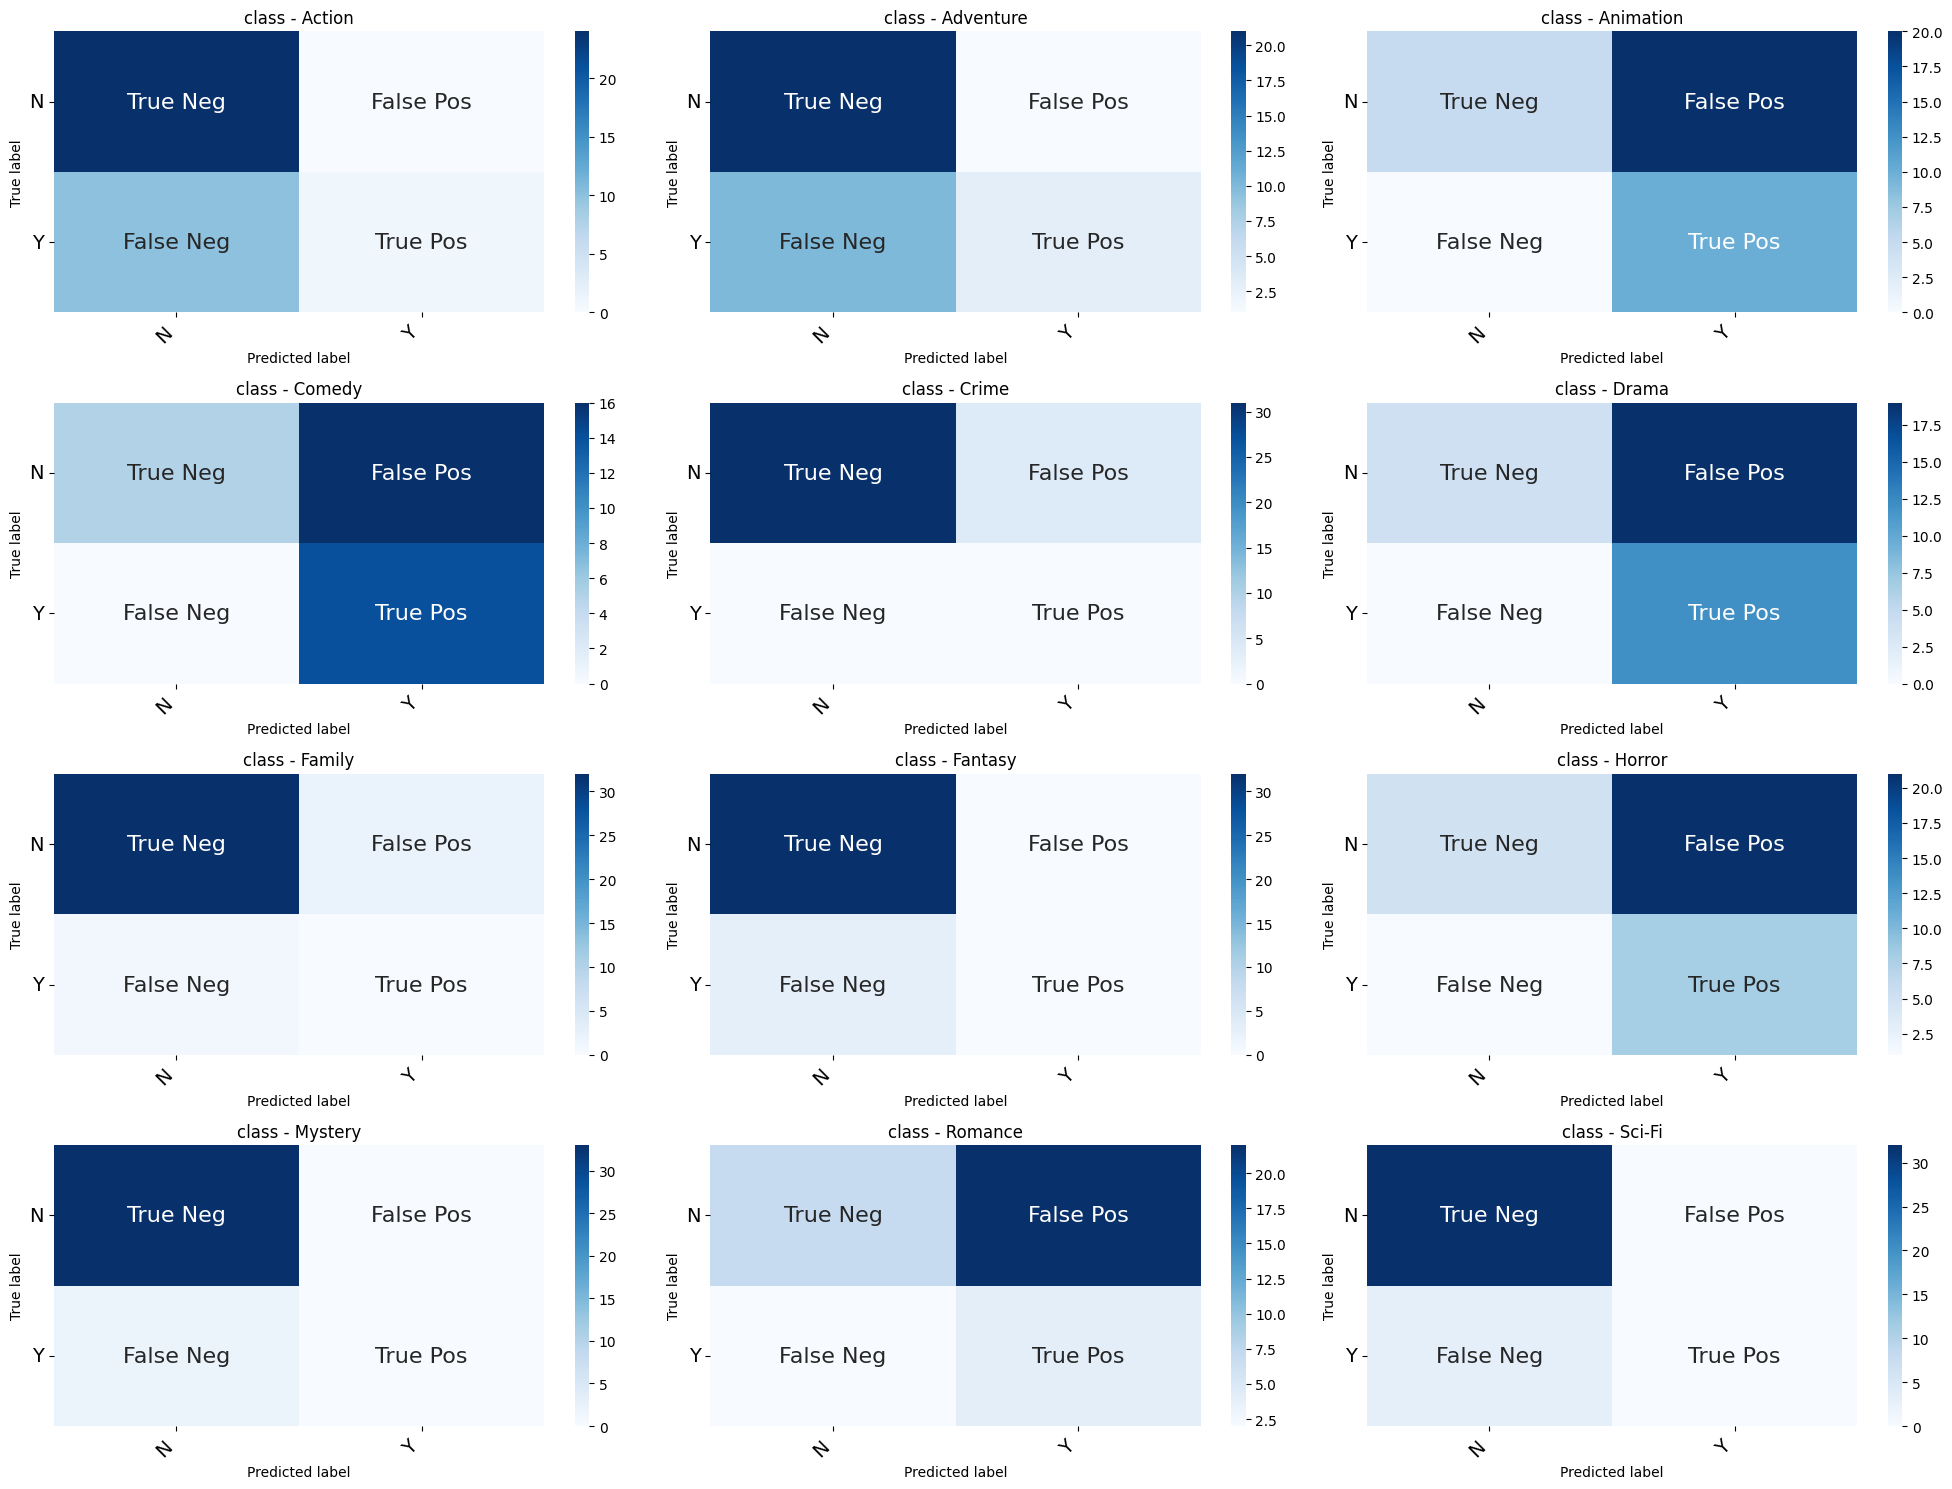

In [176]:
from sklearn.metrics import multilabel_confusion_matrix

# for each genre, plot its confusion matrix
y_pred = grid_search.predict(X_test)
matr = multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
    
for axes, cfs_matrix, label in zip(ax.flatten(), matr, multilabel_binarizer.classes_):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()


Our model quite often predicts some false positives, for classes: Romance, Horror, Drama, Animation and Comedy. Let's see if that is true.. We save our model and binarizer, to be used in our api for inference.

In [181]:
import joblib
# save model and multilabel binarizer
joblib.dump(grid_search, 'models/movie_model_pipeline.pkl')
joblib.dump(multilabel_binarizer, 'models/binarizer.pkl')

['models/binarizer.pkl']

In [ ]:
# EXTRA.. can be used to train a model with pretrained BERT

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.base import BaseEstimator, TransformerMixin

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

num_classes = len(multilabel_binarizer.classes_)

# BERT-based Feature Extractor with Fine-Tuning
class BertFineTunedFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=128, batch_size=16, num_epochs=3, learning_rate=2e-5):
        self.max_length = max_length
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None

    def fit(self, X, y):
        # Convert data to tensors
        X_tensors = tokenizer(list(X), padding=True, truncation=True, return_tensors='pt')
        y_tensors = torch.FloatTensor(y)
        
        # Create DataLoader for batching
        train_dataset = torch.utils.data.TensorDataset(X_tensors['input_ids'], X_tensors['attention_mask'], y_tensors)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        # Fine-tuning loop
        self.model = NeuralNetwork(num_classes=num_classes).to(self.device)
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        total_steps = len(train_loader) * self.num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        criterion = torch.nn.BCEWithLogitsLoss()

        for epoch in range(self.num_epochs):
            total_loss = 0.0
            self.model.train()
            for step, batch in enumerate(train_loader):
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(self.device), attention_mask.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {average_loss:.4f}")

        return self

    def transform(self, X):
        # Convert data to tensors
        X_tensors = tokenizer(list(X), padding=True, truncation=True, return_tensors='pt')
        
        # Move the model to the appropriate device (GPU or CPU)
        self.model = self.model.to(self.device)
        self.model.eval()

        with torch.no_grad():
            # Get the BERT embeddings
            X_tensors = {key: value.to(self.device) for key, value in X_tensors.items()}
            embeddings = self.model(input_ids=X_tensors['input_ids'], attention_mask=X_tensors['attention_mask'])
            
        return embeddings


# Define the NeuralNetwork class
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNetwork, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768, 256)  # Adjust the input size to match BERT output (768 for 'bert-base-uncased')
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        # Apply fully connected layers
        x = self.fc1(pooled_output)
        x = nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = self.fc2(x)
        return x


# Update the data pipeline
bert_pipeline = Pipeline([
    ("bert_features", BertFineTunedFeatureExtractor(batch_size=16, num_epochs=3, learning_rate=2e-5)),  # The fine-tuned BERT-based pipeline
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

X_train_plot = X_train['Plot']
# Fit the pipeline with the fine-tuned BERT embeddings
data_pipeline.fit(X_train_plot, y_train)